# Numba implementation of greedy search

Allow just-in-time compilation with numba.

## Test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [36]:
import numpy as np
import pandas as pd

RNG = np.random.default_rng(seed=0)

In [4]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [38]:
d_tiny = rand_array((10, 5), alpha=0.5)
d_tiny

array([[0, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 1, 0],
       [1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1]])

In [136]:
ns = np.arange(5, 51, 5)
ms = np.arange(50, 501, 50)

alpha = 0.5

d = {}
for i in ms:
    for j in ns:
        X = rand_array((i, j), alpha=alpha)
        y = rand_array((i, 1), alpha=alpha)
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y[:,-1])
        d[(i, j)] = (dfX, dfy)


## Existing implementation

In [42]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='greedy'))

def re_fit(data):
  re.fit(data[0], data[1])

In [45]:
t_bm = {}

for i in ms:
    t_bm[(i, ns[0])] = %timeit -o re_fit(d[(i, ns[0])])

for i in ns:
    t_bm[(ms[0], i)] = %timeit -o re_fit(d[(ms[0], i)])

734 ns ± 102 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
627 ns ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
637 ns ± 59.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
623 ns ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
784 ns ± 138 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
842 ns ± 204 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
773 ns ± 128 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
877 ns ± 122 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
778 ns ± 167 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.28 µs ± 605 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


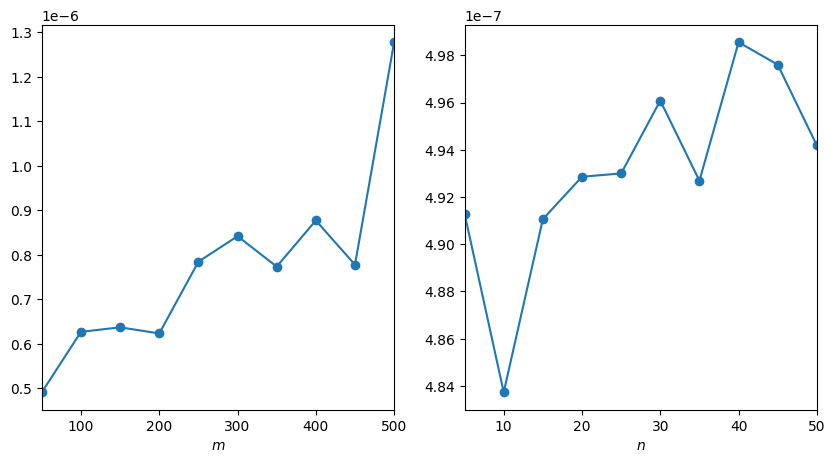

In [137]:
import matplotlib.pyplot as plt

t_bm_mean = [t_bm[(i, ns[0])].average for i in ms]
t_bm_std = [t_bm[(i, ns[0])].stdev for i in ms]
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ms, t_bm_mean, marker='o')
plt.xlim(ms[0], ms[-1])
plt.xlabel('$m$')

plt.subplot(1, 2, 2)
t_bm_mean = [t_bm[(ms[0], j)].average for j in n]
t_bm_std = [t_bm[(ms[0], j)].stdev for j in n]
plt.plot(ns, t_bm_mean, marker='o')
plt.xlim(ns[0], ns[-1])
plt.xlabel('$n$')

plt.show()

## Numba just-in-time compilation

Using sortednp allows to avoid a slow Python loop for computing the merge intersections (instead using a fast C-loop). However, the close-by-one algorithm still has a nested Python for-loop over attributes. To eliminate this, we can use just-in-time compilation with the numba package. However, this requires a couple of further modifications:

1. We have to convert our Python incidence lists to numba typed lists. Otherwise numba would map our Python lists to untyped reflected lists, which would require the C-loop to inspect every list element and check for its type (removing any speed-up).

2. We have to re-implement the merge intersection, because numba does not support sortednp.

3. We have to eliminate the default arguments for the close-by-one procedure to have fixed-type compilable signatures. There are probably other solutions for this based on advanced numba features.


In [60]:
# from realkd.search import GreedySearch
# from numba import njit

# @njit
# def count_concepts_sl_numba(ints, exts):
#     pass

In [139]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit
import pandas as pd
import sortednp as snp
import doctest

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc

from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='numba_greedy'))

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    # @njit
    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))
    return objective_function

@njit
def my_intersect(arr1, arr2):
    return np.array(set(arr1).intersection(arr2))

@njit()
def JitListComp(l1, l2):
    l3 = np.array([i for i in l1 for j in l2 if i == j])
    return np.unique(l3)

# @njit
def find_best_new_index(current_intent, current_extent , extents, initial_value, f, n):
    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        if i in current_intent:
            continue
        new_extent = JitListComp(current_extent, extents[i])
        new_value = f(new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

# @njit
def numba_run(extent, n, extents, f):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    intent = [-1]
    value = f(extent)
    while True:
        best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
        if best_i is not None:
            # Update intent and try again
            intent.append(best_i)
            extent = best_ext
            value = new_value
        else:
            # Intent can't get any better
            break
    return intent[1:]

class NumbaGreedySearch:
    def __init__(self, ctx, obj, bdn=None, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.f = obj
        self.verbose = verbose

    def run(self):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        # The context is essentially the "current" intent and extent
        # Also note intent implies extent
        # Initially all row indexes from existing extent are selected (i.e intent = [])
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = self.ctx.extents
        attributes = self.ctx.attributes
        # Intent is a list of COLUMN indexes to select by
        intent = numba_run(initial_extent, n, extents, self.f)
        print(initial_extent)
        print(intent)
        if not len(intent) == 0:
            print(snp.intersect(initial_extent, extents[intent.pop()]))
        print(n)
        return Conjunction(map(lambda i: attributes[i], intent))


def run_search(data):
    objective_function = build_numba_obj_function(data[0], data[1])
    search = NumbaGreedySearch(ctx=Context.from_df(data[0]), obj=objective_function, bdn=None)
    search.run()

run_search(d[ms[0], ns[0]])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[]


IndexError: pop from empty list

In [98]:
t_numba = {}

for i in m:
    t_numba[(i, n[0])] = %timeit -o run_search(d[(i, n[0])])

for i in n:
    t_numba[(m[0], i)] = %timeit -o run_search(d[(m[0], i)])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7f71ad2d0580>.
missing a required argument: 'ext'
During: resolving callee type: type(CPUDispatcher(<function objective_function at 0x7f71ad25cc10>))
During: typing of call at /tmp/ipykernel_8665/1607353517.py (45)

Enable logging at debug level for details.

File "../../../../../tmp/ipykernel_8665/1607353517.py", line 45:
<source missing, REPL/exec in use?>


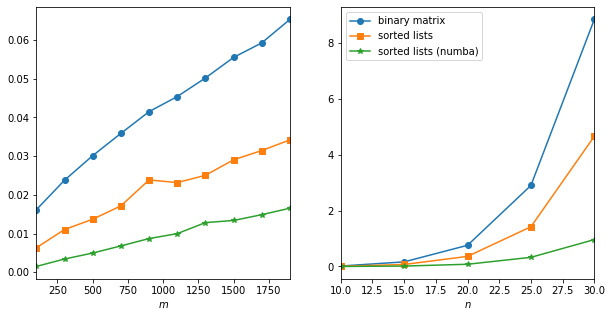

In [26]:
plt.subplots(1, 2, figsize=(10, 5))

t_bm_mean = [t_bm[(i, 10)].average for i in m]
t_bm_std = [t_bm[(i, 10)].stdev for i in m]
t_sl_numba_mean = [t_sl_numba[(i, 10)].average for i in m]
t_sl_numba_std = [t_sl_numba[(i, 10)].stdev for i in m]

plt.subplot(1, 2, 1)
plt.plot(m, t_bm_mean, marker='o')
plt.plot(m, t_sl_numba_mean, marker='*')
plt.xlim(m[0], m[-1])
plt.xlabel('$m$')

t_bm_mean = [t_bm[(m[0], j)].average for j in n[:5]]
t_bm_std = [t_bm[(m[0], j)].stdev for j in n[:5]]
t_sl_numba_mean = [t_sl_numba[(m[0], j)].average for j in n[:5]]
t_sl_numba_std = [t_sl_numba[(m[0], j)].stdev for j in n[:5]]

plt.subplot(1, 2, 2)
plt.plot(n[:5], t_bm_mean, marker='o', label='binary matrix')
plt.plot(n[:5], t_sl_numba_mean, marker='*', label='sorted lists (numba)')
plt.xlim(n[0], n[4])
plt.xlabel('$n$')
plt.legend()

plt.show()